In [5]:
# импортируем бэкенд Agg из matplotlib для сохранения графиков на диск
import matplotlib
matplotlib.use("Agg")

In [6]:
# Подключаем необходимые модули и пакеты
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from tensorflow.keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3950186042604016849,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5717884928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16774453120724326187
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6"]

### Подготовим dataset
Сконвертируем имеющиеся .png изображения к .jpg

In [10]:
# convert all images in directory from png to jpg
import os 
from PIL import Image 


def rotate_and_save(img_path, angle):
    img = Image.open(img_path)
    newImg = img.resize((img.size[0], img.size[0])).rotate(angle)

    newfileName = img_path[:-4] + f"r{angle}" + ".jpg"

    newImg.save(newfileName)

path = './onepiece_dataset'

# Iterate over all the files in directory 
for file in paths.list_images(path):
    rotate_and_save(file, 0)
    rotate_and_save(file, 90)
    rotate_and_save(file, 180)
    rotate_and_save(file, 270)

In [ ]:
import PIL.ImageOps
from PIL import Image 
  
# Path of the directory containing 
# the png images 
path = './onepiece_dataset'

def invertImg(img_path):
    img = Image.open(img_path)
    newImg = PIL.ImageOps.invert(img)

    newfileName = img_path[:-4] + "n" + ".jpg"

    newImg.save(newfileName)

#for file in paths.list_images(path): 
#    invertImg(file)

In [ ]:
def sharr_detection(img_path):
    img = Image.open(img_path)
    newImg = PIL.ImageOps

In [16]:
# инициализируем данные и метки
print("[INFO] loading images...")
data = []
labels = []

[INFO] loading images...


In [17]:
# Собираем список путей к каждому изображению и перемешиваем их
sq_images = filter(lambda x: 'r' in x, paths.list_images("./onepiece_dataset"))

imagePaths = sorted(list(sq_images))

random.shuffle(imagePaths)

In [18]:
#progressbar
from tqdm import tqdm

# цикл по изображениям
for imagePath in tqdm(imagePaths, total=len(imagePaths)):

    image = cv2.imread(imagePath) # загружаем изображение
    image = cv2.resize(image, (32, 32)).flatten() # меняем его разрешение на 32x32 пикселей (без учета соотношения сторон),
    # сглаживаем его в 32x32x3=3072 пикселей
    data.append(image) # добавляем в список

    label = imagePath.split(os.path.sep)[-2] 	# извлекаем метку класса из пути к изображению (метка класса зависит от имени папки)
    labels.append(label) # обновляем список меток

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:10<00:00, 280.27it/s]


In [50]:
set(labels)

{'Luffy', 'Sanji', 'Shanks', 'Usopp'}

In [19]:
# масштабируем интенсивности пикселей в диапазон [0, 1] (Нормализация данных)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [20]:
# разбиваем данные на обучающую и тестовую выборки, используя 75%
# данных для обучения и оставшиеся 25% для тестирования
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

In [21]:
# конвертируем метки из целых чисел в векторы (для 2х классов при
# бинарной классификации вам следует использовать функцию Keras
# "to_categorical" вместо "LabelBinarizer" из scikit-learn, которая не возвращает вектор)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [22]:
# определим архитектуру 3072-1024-512-3 с помощью Keras
model = Sequential()
model.add(Dense(512, input_shape=(3072,), activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(len(lb.classes_), activation="softmax"))

In [23]:
# инициализируем скорость обучения и общее число эпох
INIT_LR = 0.01
EPOCHS = 500

In [24]:
# компилируем модель, используя SGD как оптимизатор и категориальную
# кросс-энтропию в качестве функции потерь (для бинарной классификации
# следует использовать binary_crossentropy)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] training network...


C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [25]:
# обучаем нейросеть
H = model.fit(trainX, trainY, validation_data=(testX, testY),
    epochs=EPOCHS, batch_size=500)

Epoch 1/500
5/5 [==============================] - 2s 73ms/step - loss: 1.4805 - accuracy: 0.2632 - val_loss: 1.4327 - val_accuracy: 0.2497
Epoch 2/500
5/5 [==============================] - 0s 15ms/step - loss: 1.3796 - accuracy: 0.3005 - val_loss: 1.4497 - val_accuracy: 0.2888
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 1.3539 - accuracy: 0.3522 - val_loss: 1.3719 - val_accuracy: 0.3185
Epoch 4/500
5/5 [==============================] - 0s 14ms/step - loss: 1.3245 - accuracy: 0.3684 - val_loss: 1.3576 - val_accuracy: 0.3320
Epoch 5/500
5/5 [==============================] - 0s 14ms/step - loss: 1.3064 - accuracy: 0.3950 - val_loss: 1.3346 - val_accuracy: 0.3671
Epoch 6/500
5/5 [==============================] - 0s 14ms/step - loss: 1.3092 - accuracy: 0.3932 - val_loss: 1.3989 - val_accuracy: 0.3482
Epoch 7/500
5/5 [==============================] - 0s 14ms/step - loss: 1.2954 - accuracy: 0.4238 - val_loss: 1.3125 - val_accuracy: 0.3617
Epoch 8/500
5/5 [===

5/5 [==============================] - 0s 14ms/step - loss: 1.0745 - accuracy: 0.5556 - val_loss: 1.2330 - val_accuracy: 0.4548
Epoch 60/500
5/5 [==============================] - 0s 15ms/step - loss: 1.0259 - accuracy: 0.5942 - val_loss: 1.1898 - val_accuracy: 0.4602
Epoch 61/500
5/5 [==============================] - 0s 15ms/step - loss: 1.0531 - accuracy: 0.5700 - val_loss: 1.1840 - val_accuracy: 0.4791
Epoch 62/500
5/5 [==============================] - 0s 14ms/step - loss: 1.0014 - accuracy: 0.6149 - val_loss: 1.1905 - val_accuracy: 0.4939
Epoch 63/500
5/5 [==============================] - 0s 14ms/step - loss: 0.9915 - accuracy: 0.6199 - val_loss: 1.2019 - val_accuracy: 0.4858
Epoch 64/500
5/5 [==============================] - 0s 15ms/step - loss: 1.0170 - accuracy: 0.5951 - val_loss: 1.1561 - val_accuracy: 0.4980
Epoch 65/500
5/5 [==============================] - 0s 14ms/step - loss: 1.0361 - accuracy: 0.5965 - val_loss: 1.2233 - val_accuracy: 0.4575
Epoch 66/500
5/5 [========

5/5 [==============================] - 0s 14ms/step - loss: 0.8303 - accuracy: 0.7027 - val_loss: 1.1422 - val_accuracy: 0.5142
Epoch 118/500
5/5 [==============================] - 0s 14ms/step - loss: 0.8805 - accuracy: 0.6599 - val_loss: 1.2526 - val_accuracy: 0.4629
Epoch 119/500
5/5 [==============================] - 0s 14ms/step - loss: 0.8962 - accuracy: 0.6433 - val_loss: 1.1159 - val_accuracy: 0.5236
Epoch 120/500
5/5 [==============================] - 0s 15ms/step - loss: 0.8341 - accuracy: 0.7157 - val_loss: 1.2243 - val_accuracy: 0.4372
Epoch 121/500
5/5 [==============================] - 0s 14ms/step - loss: 0.9668 - accuracy: 0.6095 - val_loss: 1.2395 - val_accuracy: 0.4831
Epoch 122/500
5/5 [==============================] - 0s 14ms/step - loss: 0.9704 - accuracy: 0.5965 - val_loss: 1.2169 - val_accuracy: 0.4791
Epoch 123/500
5/5 [==============================] - 0s 15ms/step - loss: 0.8552 - accuracy: 0.6752 - val_loss: 1.2348 - val_accuracy: 0.4534
Epoch 124/500
5/5 [=

Epoch 175/500
5/5 [==============================] - 0s 15ms/step - loss: 0.8028 - accuracy: 0.6757 - val_loss: 1.1137 - val_accuracy: 0.5142
Epoch 176/500
5/5 [==============================] - 0s 14ms/step - loss: 0.7168 - accuracy: 0.7418 - val_loss: 1.1174 - val_accuracy: 0.5223
Epoch 177/500
5/5 [==============================] - 0s 15ms/step - loss: 0.7347 - accuracy: 0.7287 - val_loss: 1.1970 - val_accuracy: 0.4804
Epoch 178/500
5/5 [==============================] - 0s 15ms/step - loss: 0.7716 - accuracy: 0.7031 - val_loss: 1.1168 - val_accuracy: 0.5169
Epoch 179/500
5/5 [==============================] - 0s 15ms/step - loss: 0.6774 - accuracy: 0.7809 - val_loss: 1.1811 - val_accuracy: 0.5358
Epoch 180/500
5/5 [==============================] - 0s 15ms/step - loss: 0.7654 - accuracy: 0.7188 - val_loss: 1.1518 - val_accuracy: 0.4899
Epoch 181/500
5/5 [==============================] - 0s 15ms/step - loss: 0.7665 - accuracy: 0.7211 - val_loss: 1.1566 - val_accuracy: 0.5047
Epoch 

Epoch 233/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5973 - accuracy: 0.8048 - val_loss: 1.1362 - val_accuracy: 0.5182
Epoch 234/500
5/5 [==============================] - 0s 14ms/step - loss: 0.6875 - accuracy: 0.7449 - val_loss: 1.1657 - val_accuracy: 0.5263
Epoch 235/500
5/5 [==============================] - 0s 15ms/step - loss: 0.6274 - accuracy: 0.7769 - val_loss: 1.2221 - val_accuracy: 0.4831
Epoch 236/500
5/5 [==============================] - 0s 15ms/step - loss: 0.6716 - accuracy: 0.7580 - val_loss: 1.2534 - val_accuracy: 0.5155
Epoch 237/500
5/5 [==============================] - 0s 14ms/step - loss: 0.8515 - accuracy: 0.6680 - val_loss: 1.3298 - val_accuracy: 0.4224
Epoch 238/500
5/5 [==============================] - 0s 15ms/step - loss: 0.7142 - accuracy: 0.7323 - val_loss: 1.2134 - val_accuracy: 0.4926
Epoch 239/500
5/5 [==============================] - 0s 14ms/step - loss: 0.7521 - accuracy: 0.7242 - val_loss: 1.0996 - val_accuracy: 0.5601
Epoch 

Epoch 291/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5613 - accuracy: 0.8160 - val_loss: 1.1766 - val_accuracy: 0.5290
Epoch 292/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5228 - accuracy: 0.8237 - val_loss: 1.1643 - val_accuracy: 0.5128
Epoch 293/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5838 - accuracy: 0.8052 - val_loss: 1.1986 - val_accuracy: 0.5520
Epoch 294/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5902 - accuracy: 0.8075 - val_loss: 1.3906 - val_accuracy: 0.4224
Epoch 295/500
5/5 [==============================] - 0s 15ms/step - loss: 0.7973 - accuracy: 0.6820 - val_loss: 1.2636 - val_accuracy: 0.4966
Epoch 296/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5747 - accuracy: 0.8066 - val_loss: 1.2114 - val_accuracy: 0.5128
Epoch 297/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5560 - accuracy: 0.8111 - val_loss: 1.1367 - val_accuracy: 0.5452
Epoch 

Epoch 349/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5761 - accuracy: 0.7926 - val_loss: 1.1851 - val_accuracy: 0.5223
Epoch 350/500
5/5 [==============================] - 0s 14ms/step - loss: 0.3981 - accuracy: 0.8970 - val_loss: 1.0961 - val_accuracy: 0.5735
Epoch 351/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4771 - accuracy: 0.8417 - val_loss: 1.5739 - val_accuracy: 0.4278
Epoch 352/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5229 - accuracy: 0.8255 - val_loss: 1.2472 - val_accuracy: 0.5115
Epoch 353/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4438 - accuracy: 0.8646 - val_loss: 1.1751 - val_accuracy: 0.5128
Epoch 354/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4608 - accuracy: 0.8552 - val_loss: 1.2501 - val_accuracy: 0.5533
Epoch 355/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4562 - accuracy: 0.8570 - val_loss: 1.2559 - val_accuracy: 0.5007
Epoch 

Epoch 407/500
5/5 [==============================] - 0s 15ms/step - loss: 0.3801 - accuracy: 0.8799 - val_loss: 1.2726 - val_accuracy: 0.5398
Epoch 408/500
5/5 [==============================] - 0s 14ms/step - loss: 0.3862 - accuracy: 0.8736 - val_loss: 1.0984 - val_accuracy: 0.5776
Epoch 409/500
5/5 [==============================] - 0s 15ms/step - loss: 0.2879 - accuracy: 0.9447 - val_loss: 1.1210 - val_accuracy: 0.5789
Epoch 410/500
5/5 [==============================] - 0s 15ms/step - loss: 0.2745 - accuracy: 0.9492 - val_loss: 1.1161 - val_accuracy: 0.5655
Epoch 411/500
5/5 [==============================] - 0s 15ms/step - loss: 0.3444 - accuracy: 0.9024 - val_loss: 1.5728 - val_accuracy: 0.5155
Epoch 412/500
5/5 [==============================] - 0s 17ms/step - loss: 0.5036 - accuracy: 0.8219 - val_loss: 1.2547 - val_accuracy: 0.5196
Epoch 413/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4440 - accuracy: 0.8534 - val_loss: 1.4533 - val_accuracy: 0.4858
Epoch 

Epoch 465/500
5/5 [==============================] - 0s 14ms/step - loss: 0.2124 - accuracy: 0.9681 - val_loss: 1.1828 - val_accuracy: 0.5520
Epoch 466/500
5/5 [==============================] - 0s 14ms/step - loss: 0.2484 - accuracy: 0.9415 - val_loss: 1.2637 - val_accuracy: 0.5452
Epoch 467/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4115 - accuracy: 0.8484 - val_loss: 1.1816 - val_accuracy: 0.5452
Epoch 468/500
5/5 [==============================] - 0s 14ms/step - loss: 0.2682 - accuracy: 0.9370 - val_loss: 1.2293 - val_accuracy: 0.5682
Epoch 469/500
5/5 [==============================] - 0s 14ms/step - loss: 0.2379 - accuracy: 0.9568 - val_loss: 1.1404 - val_accuracy: 0.5452
Epoch 470/500
5/5 [==============================] - 0s 14ms/step - loss: 0.2571 - accuracy: 0.9456 - val_loss: 1.4495 - val_accuracy: 0.5223
Epoch 471/500
5/5 [==============================] - 0s 14ms/step - loss: 0.7297 - accuracy: 0.7683 - val_loss: 1.5328 - val_accuracy: 0.5344
Epoch 

In [26]:
# оцениваем нейросеть
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       Luffy       0.38      0.44      0.41       133
       Sanji       0.57      0.81      0.67       213
      Shanks       0.63      0.46      0.53       195
       Usopp       0.55      0.41      0.47       200

    accuracy                           0.54       741
   macro avg       0.53      0.53      0.52       741
weighted avg       0.55      0.54      0.53       741



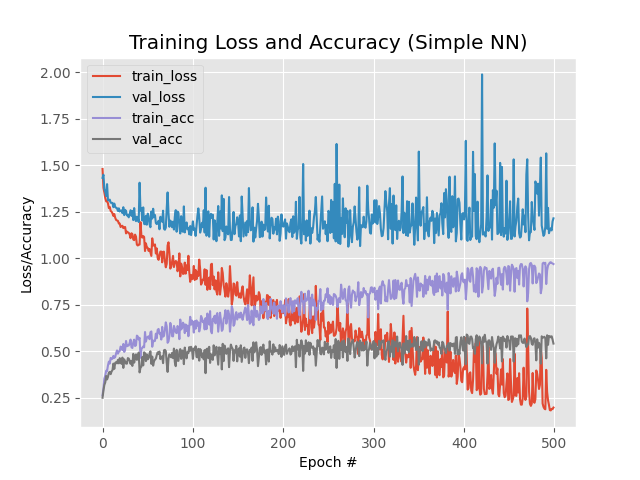

In [40]:
from IPython.display import Image

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('plot-adam.png')


Image('plot-adam.png')

In [47]:
# сохраняем модель и метки классов в бинарном представлении на диск
print("[INFO] serializing network and label binarizer...")
model.save("model.h5", save_format="h5")
f = open("label_bin", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network and label binarizer...


# Проверка обученной молели

In [42]:
from keras.models import load_model
import matplotlib.pyplot as plt
import argparse
import pickle
import cv2

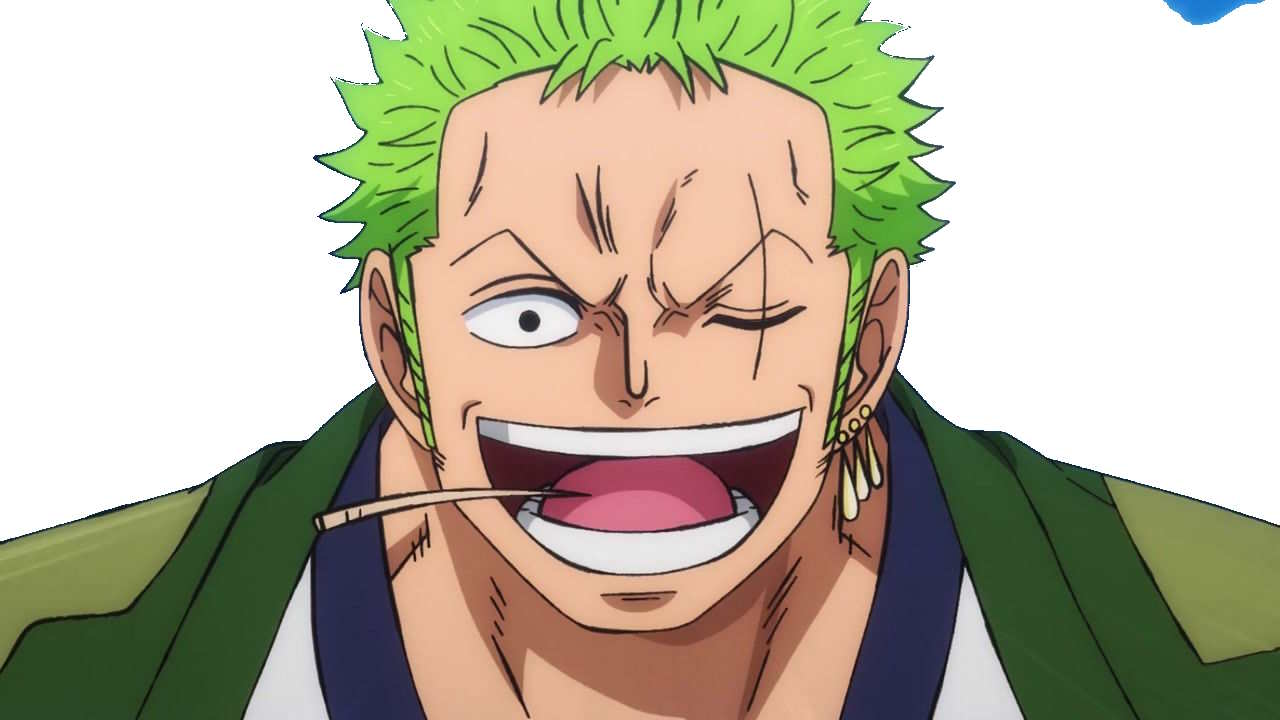

In [43]:
from IPython.display import Image

# open an image file using opencv
imagepath = './f5c7e750a5f09d7caa46ba4e5a86af86.jpg'
Image(imagepath)

In [44]:
image = cv2.imread(imagepath)
output = image.copy()

image = cv2.resize(image, (32, 32))
# "Выравниваем" изображение (преобразуем его в вектор. Из 32х32х3 -> 3072)
image = image.flatten()
# масштабируем значения пикселей к диапазону [0, 1]
image = image.astype("float") / 255.0
image = image.reshape((1, image.shape[0]))

In [48]:
# загружаем модель и бинаризатор меток
from keras import models    
print("[INFO] loading network and label binarizer...")
model = models.load_model("model.h5")
lb = pickle.loads(open("label_bin", "rb").read())

[INFO] loading network and label binarizer...


In [49]:
# делаем предсказание на изображении
preds = model.predict(image)
print(preds)

ValueError: in user code:

    C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\engine\input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: expected axis -1 of input shape to have value 768 but received input with shape (None, 3072)


In [86]:
# находим индекс метки класса с наибольшей вероятностью
# соответствия
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]

In [87]:
# Добавляем на исходное изображение метку класса и вероятность прогноза
text = "{}: {:.2f}%".format(label, preds[0][i] * 100)
cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,
	(0, 0, 255), 2)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 38,  72,  42],
        [ 38,  72,  42],
        [ 38,  72,  42],
        ...,
        [ 35,  73,  43],
        [ 34,  72,  42],
        [ 34,  72,  42]],

       [[ 38,  72,  42],
        [ 38,  72,  42],
        [ 38,  72,  42],
        ...,
        [ 34,  72,  42],
        [ 34,  72,  42],
        [ 33,  71,  41]],

       [[ 38,  72,  42],
        [ 38,  72,  42],
        [ 38,  72,  42],
        ...,
        [ 34,  72,  42],
        [ 33,  71,  41],
        [ 33,  71,  41]]

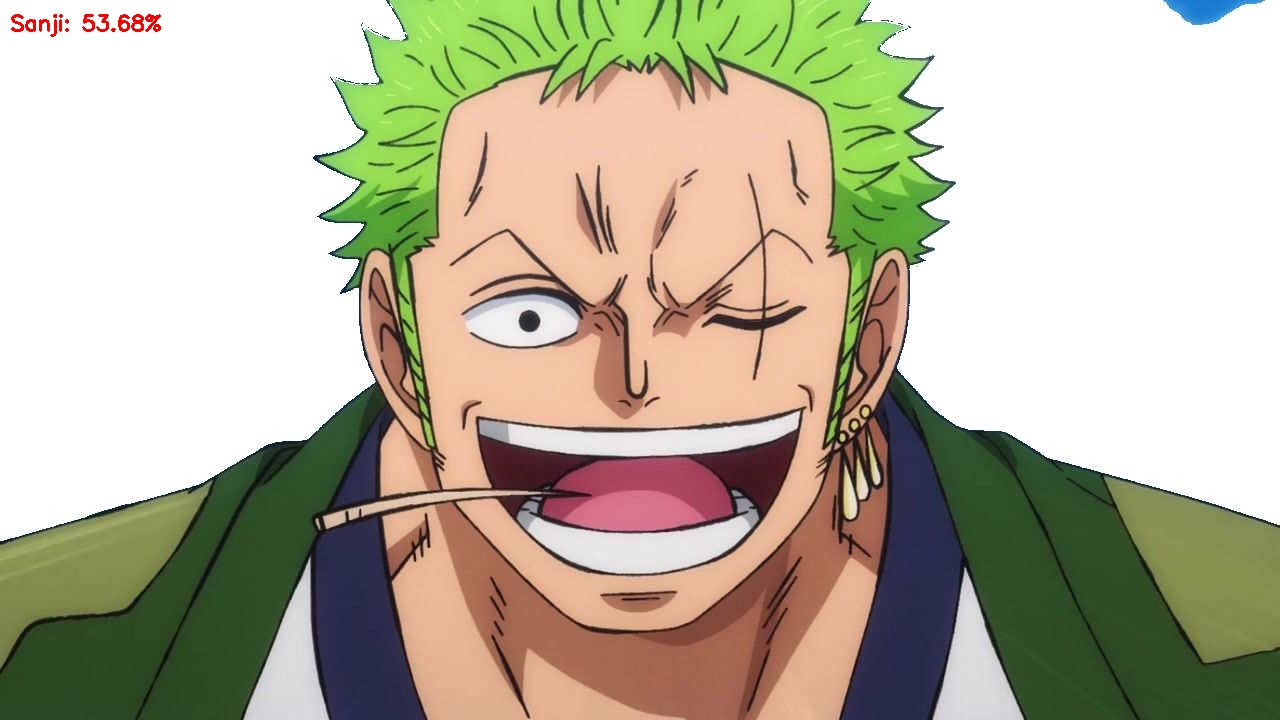

In [88]:
cv2.imwrite('output.jpg', output)
Image('output.jpg')